# Task 1

Context :  You work in a Crypto startup and you want to identify malicious Ethereum addresses. Fortunately, you have found 3 interesting datasets :

- malicious_adresses : Dataset of malicious addresses with a comment explaining the reason of suspecting the adresses. 
- malicious_transactions : Transaction data related to malicious adresses.

            * acc_name : Malicious address involve in the transaction.
            * blockNumber : The block number that the transaction was included in.
            * timeStamp : The time that the block was mined in UTC.
            * hash : A unique identifier that can be used to locate a specific transaction.
            * nonce : The count of transactions sent out of the account. The number is initialized at 0 and is incremented by 1 for each transaction sent.
            * blockHash : A unique identifier of the block. 
            * transactionIndex : Index transaction.
            * from : The address that originally sent the transaction.
            * to : The address that the transaction is addressed to.
            * value : The amount of Ether included in the transaction.
            * gas : The upper limit of how much computational work and storage the sender is willing to expend on the transaction.
            * gasPrice : The amount of Ether per unit of gas the user is willing to pay for the transaction, commonly denoted in a subunit of Ether known as Gwei. 1 Gwei = 1x10^-9 Ether.
            * isError : bolean indicate if an error occure during the transaction
            * txreceipt_status : status of the transaction, "1" means the transaction succeded, "0" means the transaction failed. 
            * input : Information that is passed to a smart contract when a transaction is sent to its address. However, if the transaction is creating a contract, the contract’s bytecode is placed in the input data field.
            * contractAdress : The contract adress related to the input.
            * cumulativeGas : Sum of gasUsed by this transaction and all preceding transactions in the same block.
            * gasUsed : The amount of computational work and storage used in the transaction.
            * confirmations : Block number that confirmed the transaction. 
            
- normal_transactions : Transaction data related to normal adresses.

Leading points :

1) Explore the datasets, if necessary clean them and keep the revelant features.

2) Analyze the addresses' behavior. What helpful statements can you make?  

3) Group the addresses in several categories based on their behavior. Justify your grouping decision.

4) Given the different groups you have created, what would you advise the business to do?  

5) Train a prediction model that predicts maliciousness based on financial behavior. How good does your model perform? How would you tweak it?

6) Given the prediction you have created, what would you advise the business to do?  
 
Feel free to use your own methodology to solve this problem. 

**Solution:**

The leading points (LP) are explored in the next sections.

LP1: 

In the Data Preprocessing and Feature Engineering section, data is cleaned and transformed, useful columns are kept and used for creation of new features regarding transactions (smart contract, sent or received), time, value, gas, and status.

LP2, LP3, LP4:

In the Exploratory Data Analysis section, Correlation Analysis is first conducted, and plots for created features are generated. 

- The addresses are grouped into malicious and normal addresses, also for further model training. It shows that they have different patterns with the created features.

- As the nature of blockchain, if the address is smart contract address (SC), or externally owned addresses (EOA) is analyzed, and if the transaction is running on smart contract is also examined, which shows that malicious addresses are mostly not contract account, they tend not to deploy or execute a smart contract either.

- The transactions are grouped into sent or received, as blockchain is a temporal bidirectional graph. The percentage of transaction shows that malicious addresses have much more transactions received than sent, which makes sense because they are involved in financial activities. 

- Values included in malicious transactions are in much smaller amount and are more centralized compared to normal transactions which has a more sparse distribution.

- Malicious addresses tend to use the upper limit of the gas or not use any gas.

- Failure and error are much more common in transactions for malicious accounts.

LP5, LP6:

In the Model Training & Evaluation section, the dataset is split into train and test with 20% split, top 30 features are selected, and five standard models are trained to predict if the address is malicious or not. In general, Random Forest and XGBoost outperform Logistic Regression, SVM and KNN, with the evaluation metrics of accuracy, precision, recall, f1 score and roc auc score. 

After hyperparameter tuning for selected random forest model, the result shows accuracy 0.95, precision 0.96, recall 0.97, f1 score 0.96.

Further optimization methods can be used to improve selected model performance. Also, the dataset contains much more malicious addresses compared to normal addresses, which causes the problem of class imbalance, this can be improved with techniques to deal with imbalanced class. In real life, most of the addresses are usually normal addresses, so instead of binary classification, anomaly detection methods could be more effective in learning normal behaviors to detect unusual activities.

With the good performance the model indicates, automated machine learning models could be helpful for companies to detect malicious activities. With feature importance entails, there are a few aspects the company could pay attention to, for example, the error handling, the abnormal value and time of transactions due to phishing and scam, and vulnerabilities of smart contract.


In [271]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import re
from wordcloud import WordCloud

from sklearn.feature_selection import SelectKBest, chi2, RFE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            roc_auc_score, confusion_matrix, classification_report

In [272]:
import warnings
warnings.filterwarnings('ignore')

# set seed for random state
seed = 0

### Dataset

In [273]:
# load dataset
df_mal_comments = pd.read_csv('./Data/malicious_comments.csv', index_col = 0)
df_mal_transactions = pd.read_csv('./Data/malicious_transactions.csv' , index_col = 0)
df_normal_transactions = pd.read_csv('./Data/normal_transactions.csv', index_col = 0)

In [3]:
df_mal_comments.head()

,address,comment,date
0,0x09750ad360fdb7a2ee23669c4503c974d86d8694,XRP phishing website (ripple.com.pt) this wall...,2020-11-17
1,0xc915eC7f4CFD1C0A8Aba090F03BfaAb588aEF9B4,XRP phishing website (ripple.com.pt) that got ...,2020-11-14
2,0xecb6ffaC05D8b4660b99B475B359FE454c77D153,XRP phishing website (ripple.com.pt) that got ...,2020-11-14
3,0x7F85A82a2da50540412F6E526F1D00A0690a77B8,XRP phishing website (ripple.com.pt) that got ...,2020-11-14
4,0xBc8b85b1515E45Fb2d74333310A1d37B879732c0,XRP phishing website (ripple.com.pt) that got ...,2020-11-14


In [4]:
# number of non-null and datatypes
df_mal_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 0 to 714
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  715 non-null    object
 1   comment  485 non-null    object
 2   date     692 non-null    object
dtypes: object(3)
memory usage: 22.3+ KB


In [5]:
# number of unique values in each column
df_mal_comments.nunique()

address    663
comment    268
date        57
dtype: int64

In [6]:
df_mal_transactions.head()

,acc_name,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations
0,0x09750ad360fdb7a2ee23669c4503c974d86d8694,11275378,1605615264,0x999c2bdb82c20445c92a6393810703ee4686b8c4ba85...,0,0x2458147a652c273e82065c8132e9c654cafb770b134e...,139,0xc28f50625cfe028ab1a3458c7cebcf9657ff1438,0x09750ad360fdb7a2ee23669c4503c974d86d8694,5.654700e+18,21000.0,4.700000e+10,0.0,1.0,0x,NaN,8249488.0,21000.0,3651513.0
1,0x09750ad360fdb7a2ee23669c4503c974d86d8694,11275378,1605615264,0x857353b26c1dac296de6dc561624f1d1e1e767ed3566...,0,0x2458147a652c273e82065c8132e9c654cafb770b134e...,180,0x22764de8f82f2d2a90e0ccca4556a2a5114b6461,0x09750ad360fdb7a2ee23669c4503c974d86d8694,5.642040e+18,21000.0,4.400000e+10,0.0,1.0,0x,NaN,12283162.0,21000.0,3651513.0
2,0x09750ad360fdb7a2ee23669c4503c974d86d8694,11275380,1605615299,0x64d3fee5a1167a09d38ae37239e8927aab90d7cc5b73...,0,0x76e327dda1a6d18cec116d289a5c20ec56a1f57b191a...,39,0x14130d36b36887620c37a404f859d11e293ec06a,0x09750ad360fdb7a2ee23669c4503c974d86d8694,5.608980e+18,21000.0,4.700000e+10,0.0,1.0,0x,NaN,3687065.0,21000.0,3651511.0
3,0x09750ad360fdb7a2ee23669c4503c974d86d8694,11275383,1605615311,0x69365605994f1b0194d9321625934cef4e7e29d49045...,0,0xd8cadc54fc2460a132299ff32076f2252bd45796b75e...,115,0x2f77f4523a13138b472ac6faef624cce68da2c46,0x09750ad360fdb7a2ee23669c4503c974d86d8694,5.640210e+18,21000.0,4.700000e+10,0.0,1.0,0x,NaN,6441939.0,21000.0,3651508.0
4,0x09750ad360fdb7a2ee23669c4503c974d86d8694,11275385,1605615331,0x006384968d5c18fbbb22cd880cd42ce893646a4c63c1...,0,0x4c87eb63ea27b2107348e6639ac6c6f5d71c3855a6e6...,142,0x2315314c5cadb895c2c9982b847fd6f6a32d6129,0x09750ad360fdb7a2ee23669c4503c974d86d8694,5.541050e+18,21000.0,4.700000e+10,0.0,1.0,0x,NaN,9526405.0,21000.0,3651506.0


In [7]:
# number of non-null and datatypes
df_mal_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21961 entries, 0 to 21960
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   acc_name           21961 non-null  object 
 1   blockNumber        21961 non-null  int64  
 2   timeStamp          21961 non-null  int64  
 3   hash               21961 non-null  object 
 4   nonce              21961 non-null  int64  
 5   blockHash          21961 non-null  object 
 6   transactionIndex   21961 non-null  int64  
 7   from               21961 non-null  object 
 8   to                 21799 non-null  object 
 9   value              21928 non-null  float64
 10  gas                21930 non-null  float64
 11  gasPrice           21934 non-null  float64
 12  isError            21932 non-null  float64
 13  txreceipt_status   13221 non-null  float64
 14  input              21932 non-null  object 
 15  contractAddress    162 non-null    object 
 16  cumulativeGasUsed  219

In [8]:
# count missing value in each column
df_mal_transactions.isna().sum()

acc_name                 0
blockNumber              0
timeStamp                0
hash                     0
nonce                    0
blockHash                0
transactionIndex         0
from                     0
to                     162
value                   33
gas                     31
gasPrice                27
isError                 29
txreceipt_status      8740
input                   29
contractAddress      21799
cumulativeGasUsed       28
gasUsed                 15
confirmations           15
dtype: int64

In [9]:
# number of unique values in each column
df_mal_transactions.nunique()

acc_name               562
blockNumber          16612
timeStamp            16612
hash                 20361
nonce                 1993
blockHash            16612
transactionIndex       327
from                 10550
to                    2797
value                 6959
gas                   1077
gasPrice               718
isError                  2
txreceipt_status         2
input                 4151
contractAddress        161
cumulativeGasUsed    18704
gasUsed               1814
confirmations        17335
dtype: int64

In [10]:
df_normal_transactions.head()

,acc_name,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from,to,value,gas,gasPrice,isError,txreceipt_status,input,contractAddress,cumulativeGasUsed,gasUsed,confirmations
0,0x6e1460c450293256694ab411ba5386ca4c7d77e6,3962491,1498993678,0xec3ec2e42a7808b01ce3c2eef6e5d9d4b37fcbdbd0a2...,115284,0xec70a1585f9bce493152562a435da00847104e0eb686...,58,0xd94c9ff168dc6aebf9b6cc86deff54f3fb0afc33,0x6e1460c450293256694ab411ba5386ca4c7d77e6,5631850900000000000,90000,20000000000,0,NaN,0x,NaN,5945581,21000,10964594
1,0x6e1460c450293256694ab411ba5386ca4c7d77e6,3962546,1498994782,0x721f98a5b1fb70c4a3afcd583b85b93c1fa2d0e95a23...,0,0x7e9c1c232730b6e6bddd0a6921e54c698be07b667197...,13,0x6e1460c450293256694ab411ba5386ca4c7d77e6,0xd0a6e6c54dbc68db5db3a091b171a77407ff7ccf,5000000000000000000,51417,21000000000,0,NaN,0x,NaN,683680,51416,10964539
2,0x6e1460c450293256694ab411ba5386ca4c7d77e6,3962546,1498994782,0x8146e52458e3194fcb95b791561e42c1bc8e2f0f4bff...,1,0x7e9c1c232730b6e6bddd0a6921e54c698be07b667197...,89,0x6e1460c450293256694ab411ba5386ca4c7d77e6,0xd0a6e6c54dbc68db5db3a091b171a77407ff7ccf,629691407000000000,36417,21000000000,0,NaN,0x,NaN,6436632,36416,10964539
3,0x6e1460c450293256694ab411ba5386ca4c7d77e6,3976725,1499237674,0x4710ad77153702597310349f6d790d6c92cc6333cfba...,48372,0x2da6ddc20577129d9e1ec5a897300328ae2e10ab09db...,125,0x69ea6b31ef305d6b99bb2d4c9d99456fa108b02a,0x6e1460c450293256694ab411ba5386ca4c7d77e6,1029900000000000000,90000,20000000000,0,NaN,0x,NaN,5986828,21000,10950360
4,0x6e1460c450293256694ab411ba5386ca4c7d77e6,3976731,1499237730,0xde6d9d5d8f7d9d39aa262be95230248fab9827b8b78b...,2,0xeeb4b23f5809838072c95977327f5231effd48b8ef38...,19,0x6e1460c450293256694ab411ba5386ca4c7d77e6,0xd0a6e6c54dbc68db5db3a091b171a77407ff7ccf,0,3141592,21000000000,0,NaN,0xd1058e59,NaN,726383,218666,10950354


In [11]:
df_normal_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   acc_name           30000 non-null  object 
 1   blockNumber        30000 non-null  int64  
 2   timeStamp          30000 non-null  int64  
 3   hash               30000 non-null  object 
 4   nonce              30000 non-null  int64  
 5   blockHash          30000 non-null  object 
 6   transactionIndex   30000 non-null  int64  
 7   from               30000 non-null  object 
 8   to                 29967 non-null  object 
 9   value              30000 non-null  object 
 10  gas                30000 non-null  int64  
 11  gasPrice           30000 non-null  int64  
 12  isError            30000 non-null  int64  
 13  txreceipt_status   11711 non-null  float64
 14  input              30000 non-null  object 
 15  contractAddress    33 non-null     object 
 16  cumulativeGasUsed  300

In [12]:
# number of unique values in each column
df_normal_transactions.nunique()

acc_name                87
blockNumber          27233
timeStamp            27233
hash                 29999
nonce                11932
blockHash            27233
transactionIndex       423
from                   945
to                    8213
value                 9277
gas                   4094
gasPrice              4046
isError                  2
txreceipt_status         2
input                10454
contractAddress         33
cumulativeGasUsed    24197
gasUsed               5652
confirmations        27268
dtype: int64

## Data Preprocessing -> LP1

In [274]:
def preprocessing_Txn(df_Txn):
    # transform data type
    
    col_object = ['acc_name', 'from', 'to', 'input', 'contractAddress']
    col_float = ['value', 'gas', 'gasPrice', 'gasUsed', 'isError', 'txreceipt_status']
    col_int = ['timeStamp']

    for column in col_object:
        df_Txn[column] = df_Txn[column].astype('object')

    for column in col_float:
       df_Txn[column] = df_Txn[column].astype('float64')

    for column in col_int:
       df_Txn[column] = df_Txn[column].astype('int64')

   # select useful columns
    col_selected = col_object + col_float + col_int
    df_Txn = df_Txn[col_selected]
    
    # convert all the addresses to lowercase
    df_Txn = df_Txn.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

    # convert timestamp to time format
    df_Txn['date'] = pd.to_datetime(df_Txn['timeStamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')))
    df_Txn['time'] = pd.to_datetime(df_Txn['timeStamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')))

    # calculate gasPrice from Gwei to Ethr, gasPrice is set by the sender
    df_Txn['gasPrice'] = df_Txn['gasPrice'].multiply(10**(-9))

    # sort by acc_name and time
    df_Txn = df_Txn.sort_values(['acc_name', 'time'])
    
    return df_Txn

In [275]:
# preprocess transactions dataset
df_mal_transactions = preprocessing_Txn(df_mal_transactions)
df_normal_transactions = preprocessing_Txn(df_normal_transactions)

In [276]:
df_mal_transactions.head()

,acc_name,from,to,input,contractAddress,value,gas,gasPrice,gasUsed,isError,txreceipt_status,timeStamp,date,time
8755,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0x97425ba35ffcbe298007684d8b8ecf0053895055,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0x,NaN,4.500170e+17,21000.0,45.0,21000.0,0.0,1.0,1517019863,2018-01-27,2018-01-27 02:24:23
8756,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0xd316b4460508e9a52c865c6bff1e4687891ed9a5,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0x,NaN,7.375470e+15,21000.0,45.0,21000.0,0.0,1.0,1517021797,2018-01-27,2018-01-27 02:56:37
8757,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0xc131bf91eb9dfac2468c775160062d619f5e2dc8,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0x,NaN,9.940800e+16,21000.0,45.0,21000.0,0.0,1.0,1517023526,2018-01-27,2018-01-27 03:25:26
8758,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0xe882c84a765af770b5778062eb9fea2417f5f09d,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0x,NaN,6.921800e+15,21000.0,45.0,21000.0,0.0,1.0,1517025970,2018-01-27,2018-01-27 04:06:10
8759,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0x37713726b81d4bc6374bb773d0882e574c64f529,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0x,NaN,4.547010e+15,21000.0,45.0,21000.0,0.0,1.0,1517056079,2018-01-27,2018-01-27 12:27:59


## Feature Engineering -> LP1

### Functions to create new features

In [277]:
def features_time(df_Txn, df_addresses):   
    # first and last transaction timeStamp
    ##df_addresses[['first_timeStamp', 'last_timeStamp']] = df_Txn.groupby('acc_name').agg(first_timeStamp = ('timeStamp', 'min'), last_timeStamp = ('timeStamp', 'max')) \
    ##                                                            .reset_index()[['first_timeStamp', 'last_timeStamp']]

    # first and last transaction time
    df_addresses[['first_time', 'last_time']] = df_Txn.groupby('acc_name').agg(first_time = ('time', 'min'), last_time = ('time', 'max')) \
                                                        .reset_index()[['first_time', 'last_time']]

    # duration between first and last transaction
    df_addresses['duration_time'] = (df_addresses['last_time'] - df_addresses['first_time']).dt.total_seconds() / 3600

    df_addresses = df_addresses.drop(['first_time', 'last_time'], axis =1)

    # average time difference between all transactions
    df_Txn['diff_time'] = df_Txn['time'].diff()
    df_Txn['diff_time'][df_Txn.acc_name != df_Txn.acc_name.shift(1)] = 0
    df_addresses['avg_diff_time'] = df_Txn.groupby('acc_name')['diff_time'].mean().reset_index()['diff_time']

    # average time difference between transactions sent and received
    df_addresses = df_addresses.merge(
                                    (df_Txn[df_Txn['isSent'] == True].groupby('acc_name')['diff_time'].mean()
                                        .reset_index(name='avg_diff_timeSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[df_Txn['isSent'] == False].groupby('acc_name')['diff_time'].mean()
                                        .reset_index(name='avg_diff_timeReceived')), on='acc_name', how='left')  
                                                  
    return(df_Txn, df_addresses)

In [278]:
def features_value(df_Txn, df_addresses):
    # total ETH value sent and received
    df_addresses = df_addresses.merge(
                                    (df_Txn[df_Txn['isSent'] == True].groupby('acc_name')['value'].sum()
                                        .reset_index(name='total_ValueSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[df_Txn['isSent'] == False].groupby('acc_name')['value'].sum()
                                        .reset_index(name='total_ValueReceived')), on='acc_name', how='left')

    # absolute value of (ValueReceived - ValueSent)
    df_addresses['diff_Value'] = abs(df_addresses['total_ValueReceived'] - df_addresses['total_ValueSent'])

    # average value sent and received 
    df_addresses['avg_ValueSent'] = df_addresses['total_ValueSent'] / df_addresses['num_TxnSent']
    df_addresses['avg_ValueReceived'] = df_addresses['total_ValueReceived'] / df_addresses['num_TxnReceived']

    # standard deviation of value sent and received
    df_addresses = df_addresses.merge(
                                    (df_Txn[df_Txn['isSent'] == True].groupby('acc_name')['value'].std()
                                        .reset_index(name='std_ValueSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[df_Txn['isSent'] == False].groupby('acc_name')['value'].std()
                                        .reset_index(name='std_ValueReceived')), on='acc_name', how='left')

    # first and last value
    df_addresses['first_Value'] = df_Txn.groupby('acc_name')['value'].first().reset_index()['value']
    df_addresses['last_Value'] = df_Txn.groupby('acc_name')['value'].last().reset_index()['value']    

    # number of zero value sent and received
    df_addresses = df_addresses.merge(
                                    (df_Txn[(df_Txn['value'] == 0) & (df_Txn['isSent'] == True)].groupby('acc_name').size()
                                        .reset_index(name='num_zero_ValueSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[(df_Txn['value'] == 0) & (df_Txn['isSent'] == False)].groupby('acc_name').size()
                                        .reset_index(name='num_zero_ValueReceived')), on='acc_name', how='left')
    
    return(df_Txn, df_addresses)

In [279]:
def features_gas(df_Txn, df_addresses):
    ##gas and gasUsed
    # gasUsed sent and received
    df_addresses = df_addresses.merge(
                                    (df_Txn[df_Txn['isSent'] == True].groupby('acc_name')['gasUsed'].sum()
                                        .reset_index(name='total_gasUsedSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[df_Txn['isSent'] == False].groupby('acc_name')['gasUsed'].sum()
                                        .reset_index(name='total_gasUsedReceived')), on='acc_name', how='left')


    # average gasUsedSent and gasUsedReceived
    df_addresses['avg_gasUsedSent'] = df_addresses['total_gasUsedSent'] / df_addresses['num_TxnSent']
    df_addresses['avg_gasUsedReceived'] = df_addresses['total_gasUsedReceived'] / df_addresses['num_TxnReceived']

    # percentage of gasUsed / gas
    df_Txn['per_gasUsed'] = df_Txn['gasUsed'] / df_Txn ['gas']

    # average per_gasUsedSent and per_gasUsedReceived
    df_addresses = df_addresses.merge(
                                    (df_Txn[df_Txn['isSent'] == True].groupby('acc_name')['per_gasUsed'].mean()
                                        .reset_index(name='avg_per_gasUsedSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[df_Txn['isSent'] == False].groupby('acc_name')['per_gasUsed'].mean()
                                        .reset_index(name='avg_per_gasUsedReceived')), on='acc_name', how='left')

    ##gasPrice
    # gasPrice sent and received
    df_addresses = df_addresses.merge(
                                    (df_Txn[df_Txn['isSent'] == True].groupby('acc_name')['gasPrice'].sum()
                                        .reset_index(name='total_gasPriceSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[df_Txn['isSent'] == False].groupby('acc_name')['gasPrice'].sum()
                                        .reset_index(name='total_gasPriceReceived')), on='acc_name', how='left')

    # average gasPrice sent and received
    df_addresses['avg_gasPriceSent'] = df_addresses['total_gasPriceSent'] / df_addresses['num_TxnSent']
    df_addresses['avg_gasPriceReceived'] = df_addresses['total_gasPriceReceived'] / df_addresses['num_TxnReceived']

    # standard deviation of gasPrice sent and received
    df_addresses = df_addresses.merge(
                                    (df_Txn[df_Txn['isSent'] == True].groupby('acc_name')['gasPrice'].std()
                                        .reset_index(name='std_gasPriceSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[df_Txn['isSent'] == False].groupby('acc_name')['gasPrice'].std()
                                        .reset_index(name='std_gasPriceReceived')), on='acc_name', how='left')

    ##fee
    # fee = gasUsed * gasPrice
    df_Txn['gasFee'] = df_Txn['gasUsed'] * df_Txn['gasPrice']

    # total gas fee
    df_addresses['total_gasFee'] = df_Txn.groupby('acc_name')['gasFee'].sum().reset_index()['gasFee']

    # gas fee sent and received
    df_addresses = df_addresses.merge(
                                    (df_Txn[df_Txn['isSent'] == True].groupby('acc_name')['gasFee'].sum()
                                        .reset_index(name='total_gasFeeSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[df_Txn['isSent'] == False].groupby('acc_name')['gasFee'].sum()
                                        .reset_index(name='total_gasFeeReceived')), on='acc_name', how='left')    
    # average gas fee sent and received
    df_addresses['avg_gasFeeSent'] = df_addresses['total_gasFeeSent'] / df_addresses['num_TxnSent']
    df_addresses['avg_gasFeeReceived'] = df_addresses['total_gasFeeReceived'] / df_addresses['num_TxnReceived']

    # standard deviation gas fee sent and received
    df_addresses = df_addresses.merge(
                                (df_Txn[df_Txn['isSent'] == True].groupby('acc_name')['gasFee'].std()
                                    .reset_index(name='std_gasFeeSent')), on='acc_name', how='left') \
                            .merge(
                                (df_Txn[df_Txn['isSent'] == False].groupby('acc_name')['gasFee'].std()
                                    .reset_index(name='std_gasFeeReceived')), on='acc_name', how='left')
                                        
    return(df_Txn, df_addresses)

In [283]:
def features_status(df_Txn, df_addresses):
    ## txreceipt status
    # this field was added around 10/16/2017 to etherscan and before that is empty
    df_addresses = df_addresses.merge((df_Txn[df_Txn['txreceipt_status'] == 0].groupby('acc_name').size()
                                    .reset_index(name='num_failed_Txn')), on='acc_name', how='left')

    # suc_Txn sent and received
    ##df_sent = df_Txn[(df_Txn['txreceipt_status'] == 1) & (df_Txn['isSent'] == True)].groupby('acc_name').size().reset_index(name='suc_TxnSent')
    ##df_received = df_Txn[(df_Txn['txreceipt_status'] == 1) & (df_Txn['isSent'] == False)].groupby('acc_name').size().reset_index(name='suc_TxnReceived')
    ##df_addresses = df_addresses.merge(df_sent, on='acc_name', how='left').merge(df_received, on='acc_name', how='left')

    # failed_Txn sent and received
    df_addresses = df_addresses.merge(
                                    (df_Txn[(df_Txn['txreceipt_status'] == 0) & (df_Txn['isSent'] == True)].groupby('acc_name').size()
                                        .reset_index(name='num_failed_TxnSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[(df_Txn['txreceipt_status'] == 0) & (df_Txn['isSent'] == False)].groupby('acc_name').size()
                                        .reset_index(name='num_failed_TxnReceived')), on='acc_name', how='left')
    # percentage of failed transactions
    df_addresses['per_failed_Txn'] = df_addresses['num_failed_Txn'] / df_addresses['num_Txn']

    ##error
    # number of error transactions
    df_addresses = df_addresses.merge((df_Txn[df_Txn['isError'] == 1].groupby('acc_name').size()
                                    .reset_index(name='num_error_Txn')), on='acc_name', how='left')
    # percentage of error transactions
    df_addresses['per_error_Txn'] = df_addresses['num_error_Txn'] / df_addresses['num_Txn']

    # error transactions sent and received
    df_addresses = df_addresses.merge(
                                    (df_Txn[(df_Txn['isError'] == 1) & (df_Txn['isSent'] == True)].groupby('acc_name').size()
                                        .reset_index(name='num_error_TxnSent')), on='acc_name', how='left') \
                                .merge(
                                    (df_Txn[(df_Txn['isError'] == 1) & (df_Txn['isSent'] == False)].groupby('acc_name').size()
                                        .reset_index(name='num_error_TxnReceived')), on='acc_name', how='left')    

    return(df_Txn, df_addresses)

### Main function

In [284]:
def feature_engineering(features_time, features_value, features_gas, features_status, df_Txn):
    ##transaction
    # total number of transactions
    df_addresses = df_Txn.groupby('acc_name').size().reset_index(name='num_Txn')

    # the address is Smart Contract account (SC) or externally owned account (EOA)
    # three types of transactions, between EOAs, EOA deploy a contract or execute of a contract already deployed, for the first deployment of a contract, 'to' field is empty
    # if malicious address is smart contract account, it's in the contracAddress
    df_addresses['isContractAccount'] = df_addresses['acc_name'].isin(df_Txn.contractAddress.unique()).astype(int)
    # if EOA running on smart contract, deploy or execute, 'to' is empty or is contract address
    df_EOA_SC = df_Txn[(df_Txn['acc_name'] == df_Txn['from']) & ((df_Txn['to'].isnull()) | (df_Txn['to'].isin(df_Txn.contractAddress.unique())))]
    df_addresses['isContractTxn'] = df_addresses['acc_name'].isin(df_EOA_SC.acc_name.unique()).astype(int)

    # number of transactions sent and received (outDegree and inDegree)
    df_Txn['isSent'] = df_Txn['acc_name'] == df_Txn['from']

    df_addresses['num_TxnSent'] = df_Txn.groupby('acc_name')['isSent'].sum().astype(int).reset_index()['isSent']
    df_addresses['num_TxnReceived'] = df_addresses['num_Txn'] - df_addresses['num_TxnSent']

    # percentage of transactions sent and received from all the transactions
    df_addresses['per_TxnSent'] = df_addresses['num_TxnSent'] / df_addresses['num_Txn']
    df_addresses['per_TxnReceived'] = df_addresses ['num_TxnReceived'] / df_addresses['num_Txn']

    # number of transactions send and received from unique addresses (Attractiveness)
    df_addresses['num_unique_TxnSent'] = df_Txn.groupby('acc_name')['from'].nunique().reset_index()['from']
    df_addresses['num_unique_TxnReceived'] = df_Txn.groupby('acc_name')['to'].nunique().reset_index()['to']

    # features regarding time, value, gas and status
    df_Txn, df_addresses = features_time(df_Txn, df_addresses)
    df_Txn, df_addresses = features_value(df_Txn, df_addresses)
    df_Txn, df_addresses = features_gas(df_Txn, df_addresses)
    df_Txn, df_addresses = features_status(df_Txn, df_addresses)

    # missing value
    df_addresses = df_addresses.fillna(0)

    return (df_Txn, df_addresses)

In [285]:
df_mal_transactions, df_mal_addresses = feature_engineering(features_time, features_value, features_gas, features_status, df_mal_transactions)
df_normal_transactions, df_normal_addresses = feature_engineering(features_time, features_value, features_gas, features_status, df_normal_transactions)

In [286]:
df_mal_addresses.head()

,acc_name,num_Txn,isContractAccount,isContractTxn,num_TxnSent,num_TxnReceived,per_TxnSent,per_TxnReceived,num_unique_TxnSent,num_unique_TxnReceived,duration_time,avg_diff_time,avg_diff_timeSent,avg_diff_timeReceived,total_ValueSent,total_ValueReceived,diff_Value,avg_ValueSent,avg_ValueReceived,std_ValueSent,std_ValueReceived,first_Value,last_Value,num_zero_ValueSent,num_zero_ValueReceived,total_gasUsedSent,total_gasUsedReceived,avg_gasUsedSent,avg_gasUsedReceived,avg_per_gasUsedSent,avg_per_gasUsedReceived,total_gasPriceSent,total_gasPriceReceived,avg_gasPriceSent,avg_gasPriceReceived,std_gasPriceSent,std_gasPriceReceived,total_gasFee,total_gasFeeSent,total_gasFeeReceived,avg_gasFeeSent,avg_gasFeeReceived,std_gasFeeSent,std_gasFeeReceived,num_failed_Txn,num_failed_TxnSent,num_failed_TxnReceived,per_failed_Txn,num_error_Txn,per_error_Txn,num_error_TxnSent,num_error_TxnReceived
0,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,127,0,0,29,98,0.228346,0.771654,90,27,1218.183333,3.453118e+13,1.380223e+14,3.906255e+12,3.813377e+19,3.755607e+19,5.776970e+17,1.314957e+18,3.832252e+17,6.808435e+18,1.787560e+18,4.500170e+17,4.337670e+17,26.0,0.0,996272.0,2058000.0,34354.206897,21000.0,0.318368,0.991224,627.0,3686.0,21.620690,37.612245,2.320926,13.851668,9.886100e+07,21454998.0,7.740600e+07,7.398275e+05,7.898571e+05,3.219466e+05,290885.034151,2.0,2.0,0.0,0.015748,2.0,0.015748,2.0,0.0
1,0x008f3db10374099a11ec263415cb88c952abeedc,13,0,0,8,5,0.615385,0.384615,5,9,895.467500,2.479756e+14,3.933646e+14,1.535320e+13,1.169966e+20,1.170001e+20,3.500000e+15,1.462458e+19,2.340002e+19,1.061862e+18,2.065911e+19,5.000000e+19,1.199660e+19,0.0,0.0,168000.0,105000.0,21000.000000,21000.0,1.000000,0.177510,168.0,150.0,21.000000,30.000000,0.000000,19.013153,6.678000e+06,3528000.0,3.150000e+06,4.410000e+05,6.300000e+05,0.000000e+00,399276.220190,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0x00e01a648ff41346cdeb873182383333d2184dd1,74,0,0,30,44,0.405405,0.594595,22,14,7164.452500,3.485409e+14,8.551396e+14,3.132773e+12,3.999000e+20,4.004330e+20,5.330280e+17,1.333000e+19,9.100751e+18,1.254261e+19,1.243754e+19,3.528140e+18,5.000000e+16,10.0,0.0,859222.0,924000.0,28640.733333,21000.0,0.730403,1.000000,1496.0,980.0,49.866667,22.272727,30.990247,2.609140,6.911117e+07,48531170.0,2.058000e+07,1.617706e+06,4.677273e+05,1.582805e+06,54791.937803,4.0,4.0,0.0,0.054054,4.0,0.054054,4.0,0.0
3,0x0153775362c3071c1860e8dbfd53ccc82fa226f5,2,0,0,1,1,0.500000,0.500000,2,2,257.209722,4.629775e+14,9.259550e+14,0.000000e+00,9.995380e+17,1.000000e+18,4.620000e+14,9.995380e+17,1.000000e+18,0.000000e+00,0.000000e+00,1.000000e+18,9.995380e+17,0.0,0.0,21000.0,21000.0,21000.000000,21000.0,1.000000,0.466667,22.0,113.0,22.000000,113.000000,0.000000,0.000000,2.835000e+06,462000.0,2.373000e+06,4.620000e+05,2.373000e+06,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0x02673ebfbfaed5891f6b14248b0e2753a8758fbf,2,0,0,1,1,0.500000,0.500000,2,2,27.478056,4.946050e+13,9.892100e+13,0.000000e+00,9.845000e+16,1.000000e+17,1.550000e+15,9.845000e+16,1.000000e+17,0.000000e+00,0.000000e+00,1.000000e+17,9.845000e+16,0.0,0.0,21000.0,21000.0,21000.000000,21000.0,0.840000,1.000000,62.0,39.0,62.000000,39.000000,0.000000,0.000000,2.121000e+06,1302000.0,8.190000e+05,1.302000e+06,8.190000e+05,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [321]:
df_mal_addresses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551 entries, 0 to 550
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   acc_name                 551 non-null    object 
 1   num_Txn                  551 non-null    int64  
 2   isContractAccount        551 non-null    int64  
 3   isContractTxn            551 non-null    int64  
 4   num_TxnSent              551 non-null    int64  
 5   num_TxnReceived          551 non-null    int64  
 6   per_TxnSent              551 non-null    float64
 7   per_TxnReceived          551 non-null    float64
 8   num_unique_TxnSent       551 non-null    int64  
 9   num_unique_TxnReceived   551 non-null    int64  
 10  duration_time            551 non-null    float64
 11  avg_diff_time            551 non-null    float64
 12  avg_diff_timeSent        551 non-null    float64
 13  avg_diff_timeReceived    551 non-null    float64
 14  total_ValueSent          5

## Exploratory Data Analysis -> LP2, LP3, LP4

### Comments Dataset

In [310]:
# format date
df_mal_comments['date'] = pd.to_datetime(df_mal_comments['date'])

# remove duplicate rows
df_mal_comments = df_mal_comments.drop_duplicates()

# take rows with comments
df_mal_comments = df_mal_comments[df_mal_comments['comment'].notna()]

# lowercase 
df_mal_comments['comment'] = df_mal_comments['comment'].map(lambda x: x.lower())

# remove links
df_mal_comments['comment'] = df_mal_comments['comment'].map(lambda x: re.sub(r'http\S+', '', x))

# remove punctuation
df_mal_comments['comment'] = df_mal_comments['comment'].map(lambda x: re.sub(r'[^\w\s]', '', x))


In [311]:
# join comments
long_string = ','.join(list(df_mal_comments['comment'].values))

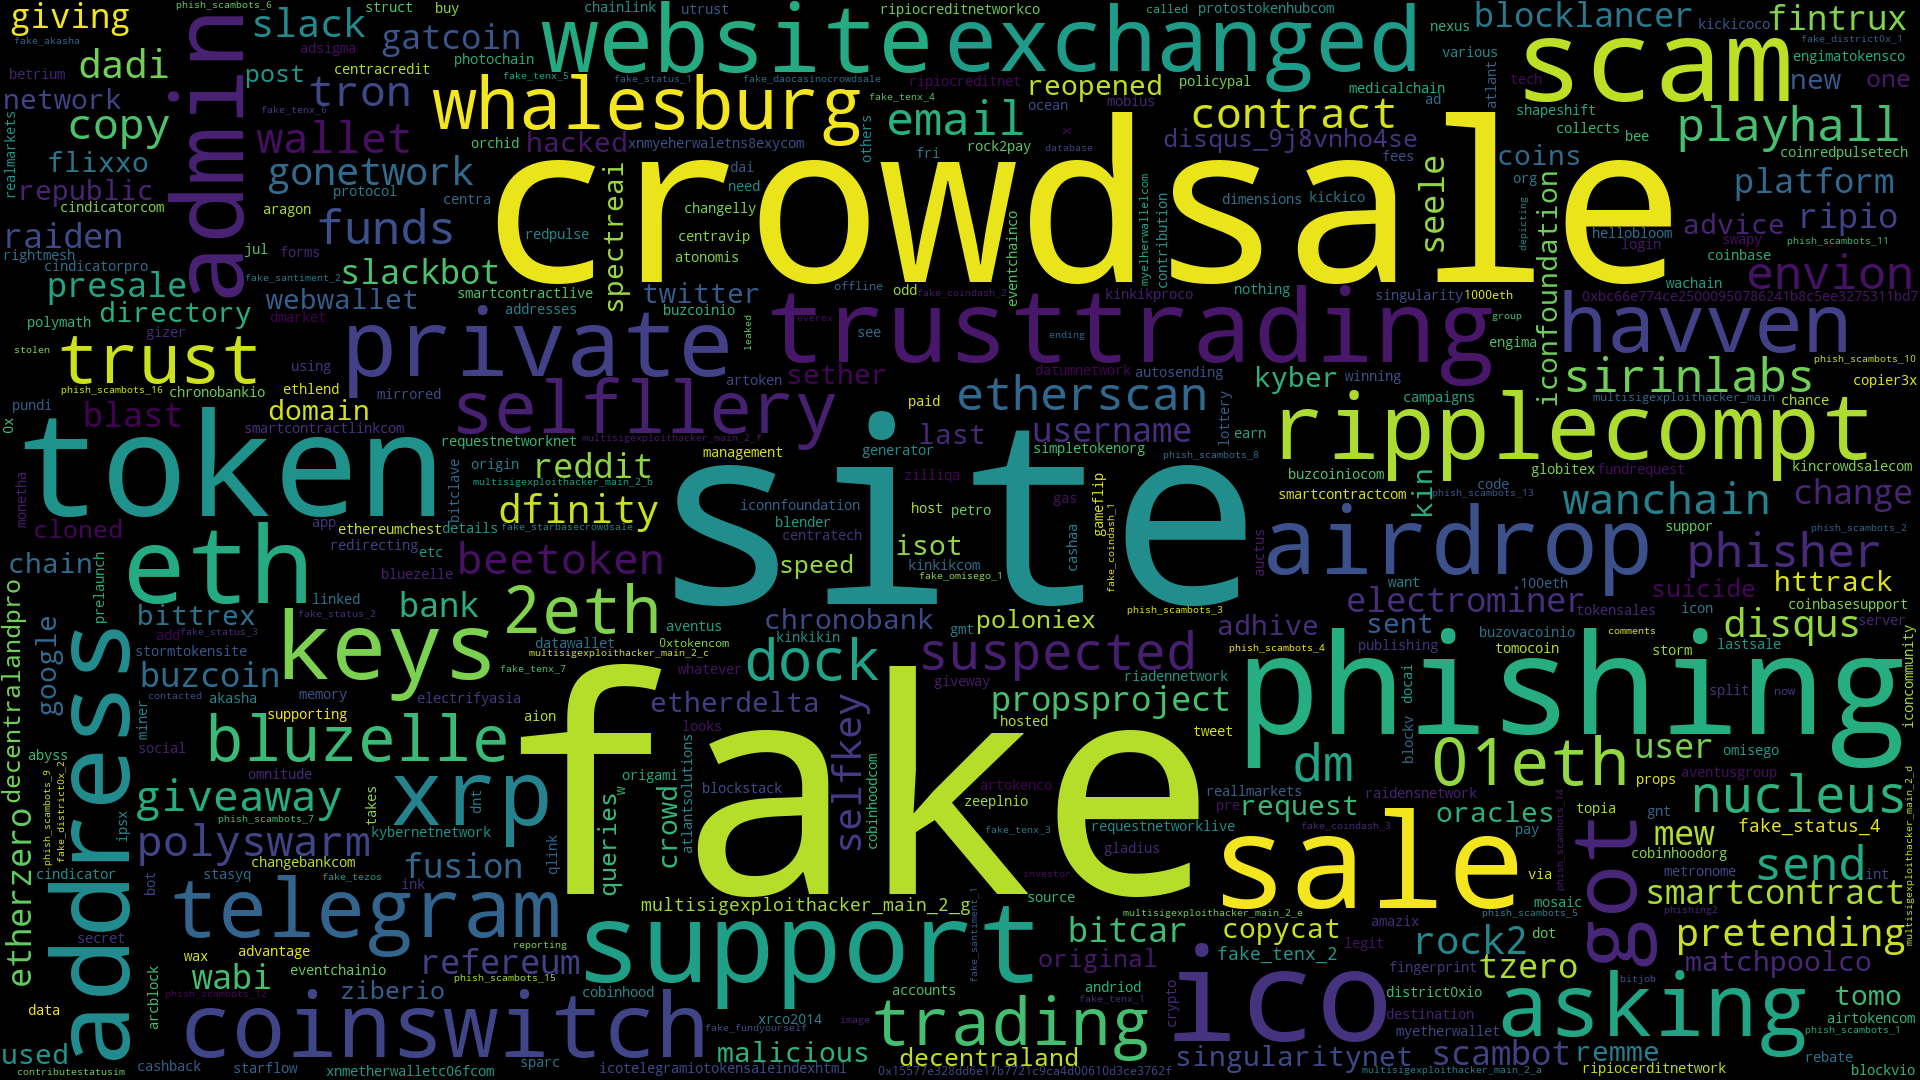

In [108]:
# create wordcloud object
wordcloud = WordCloud(collocations=False, background_color='black', width=1920, height=1080, \
    max_words=20000, max_font_size=300, random_state=seed)

# generate and visualize a word cloud
wordcloud.generate(long_string)

wordcloud.to_image()

In [109]:
wordfreq = wordcloud.words_
wordfreq

{'fake': 1.0,
 'site': 0.6966966966966966,
 'crowdsale': 0.5315315315315315,
 'token': 0.15315315315315314,
 'phishing': 0.14414414414414414,
 'sale': 0.12612612612612611,
 'ico': 0.12312312312312312,
 'scam': 0.0990990990990991,
 'support': 0.09009009009009009,
 'eth': 0.08408408408408409,
 'address': 0.08408408408408409,
 'trusttrading': 0.07507507507507508,
 'admin': 0.07207207207207207,
 'website': 0.06306306306306306,
 'airdrop': 0.06306306306306306,
 'private': 0.06306306306306306,
 'keys': 0.06306306306306306,
 'xrp': 0.06006006006006006,
 'ripplecompt': 0.06006006006006006,
 'got': 0.057057057057057055,
 'exchanged': 0.057057057057057055,
 'coinswitch': 0.057057057057057055,
 'asking': 0.05405405405405406,
 'telegram': 0.04804804804804805,
 'havven': 0.04804804804804805,
 'whalesburg': 0.042042042042042045,
 'selfllery': 0.042042042042042045,
 'trust': 0.03903903903903904,
 'trading': 0.036036036036036036,
 '01eth': 0.036036036036036036,
 '2eth': 0.036036036036036036,
 'bluzell

### Transactions Dataset

In [287]:
# add column isMal to indicate if address is malicious
df_mal_addresses['isMal'] = 1
df_normal_addresses['isMal'] = 0

# combine malicious and normal addresses
df_addresses = pd.concat([df_mal_addresses, df_normal_addresses])

# drop addresses
df = df_addresses.drop(['acc_name'], axis=1)

In [247]:
df.describe()

,num_Txn,isContractAccount,isContractTxn,num_TxnSent,num_TxnReceived,per_TxnSent,per_TxnReceived,num_unique_TxnSent,num_unique_TxnReceived,duration_time,avg_diff_time,avg_diff_timeSent,avg_diff_timeReceived,total_ValueSent,total_ValueReceived,diff_Value,avg_ValueSent,avg_ValueReceived,std_ValueSent,std_ValueReceived,first_Value,last_Value,num_zero_ValueSent,num_zero_ValueReceived,total_gasUsedSent,total_gasUsedReceived,avg_gasUsedSent,avg_gasUsedReceived,avg_per_gasUsedSent,avg_per_gasUsedReceived,total_gasPriceSent,total_gasPriceReceived,avg_gasPriceSent,avg_gasPriceReceived,std_gasPriceSent,std_gasPriceReceived,total_gasFee,total_gasFeeSent,total_gasFeeReceived,avg_gasFeeSent,avg_gasFeeReceived,std_gasFeeSent,std_gasFeeReceived,num_failed_Txn,num_failed_TxnSent,num_failed_TxnReceived,num_error_Txn,num_error_TxnSent,num_error_TxnReceived,isMal
count,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,638.000000,638.000000,6.380000e+02,6.380000e+02,638.000000,6.380000e+02,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,6.380000e+02,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000
mean,81.443574,0.222571,0.039185,53.056426,28.387147,0.335857,0.664143,20.468652,22.387147,6194.828147,1.464982e+15,1.778792e+15,1.180995e+15,8.535212e+21,3.175253e+21,5.504305e+21,4.793679e+19,5.166375e+20,4.381546e+19,5.292724e+20,1.329828e+20,1.768182e+19,22.920063,1.757053,4.011814e+06,1.071053e+06,29755.034287,9.785644e+04,0.629396,0.635918,1969.917477,1051.936349,25.793884,29.114151,7.563340,16.058895,2.275343e+08,1.995370e+08,2.799730e+07,1.068676e+06,1.052703e+06,1.096746e+06,9.594067e+05,1.835423,1.742947,0.092476,3.147335,2.793103,0.354232,0.863636
std,452.708596,0.416299,0.194187,434.975165,101.097986,0.298914,0.298914,87.591772,201.295542,11507.857080,6.182525e+15,8.602215e+15,5.962927e+15,2.018467e+23,6.749798e+22,1.344541e+23,4.982921e+20,1.124247e+22,4.603592e+20,1.158852e+22,1.076560e+21,2.058423e+20,127.528142,5.533591,2.846600e+07,3.619786e+06,53166.883302,2.078305e+05,0.412398,0.264558,16023.171955,5019.981351,26.902878,20.082483,18.433400,23.786011,2.305595e+09,2.289415e+09,1.274120e+08,2.507611e+06,2.736751e+06,5.281164e+06,3.765003e+06,9.742503,9.706028,1.015998,16.664204,15.641123,5.918858,0.343444
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000600,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,2.100000e+04,0.000000,2.058824e+04,0.000000,0.082000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,8.400000e+04,0.000000e+00,4.200000e+04,0.000000e+00,4.200000e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,1.000000,2.250000,0.020862,0.466426,3.000000,2.000000,108.406597,3.202988e+13,3.232500e+11,2.689586e+12,2.892078e+16,2.535405e+17,1.275000e+14,9.512500e+15,1.000000e+17,0.000000e+00,0.000000e+00,4.000000e+15,0.000000e+00,0.000000,0.000000,2.100000e+04,7.121400e+04,21000.000000,2.100000e+04,0.100000,0.410791,5.000000,32.000000,3.000000,16.883361,0.000000,1.414214,2.859718e+06,1.050000e+05,2.356274e+06,6.510000e+04,4.812525e+05,0.000000e+00,1.493447e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,10.000000,0.000000,0.000000,2.000000,7.000000,0.319091,0.680909,5.000000,2.000000,1060.475278,2.160706e+14,1.085910e+14,3.234209e+13,5.588080e+18,5.826410e+18,1.789000e+15,1.077610e+18,8.820221e+17,3.910300e+15,6.418560e+17,2.609295e+17,1.878418e+17,0.000000,0.000000,4.200000e+04,3.780000e+05,21000.000000,2

### Plots

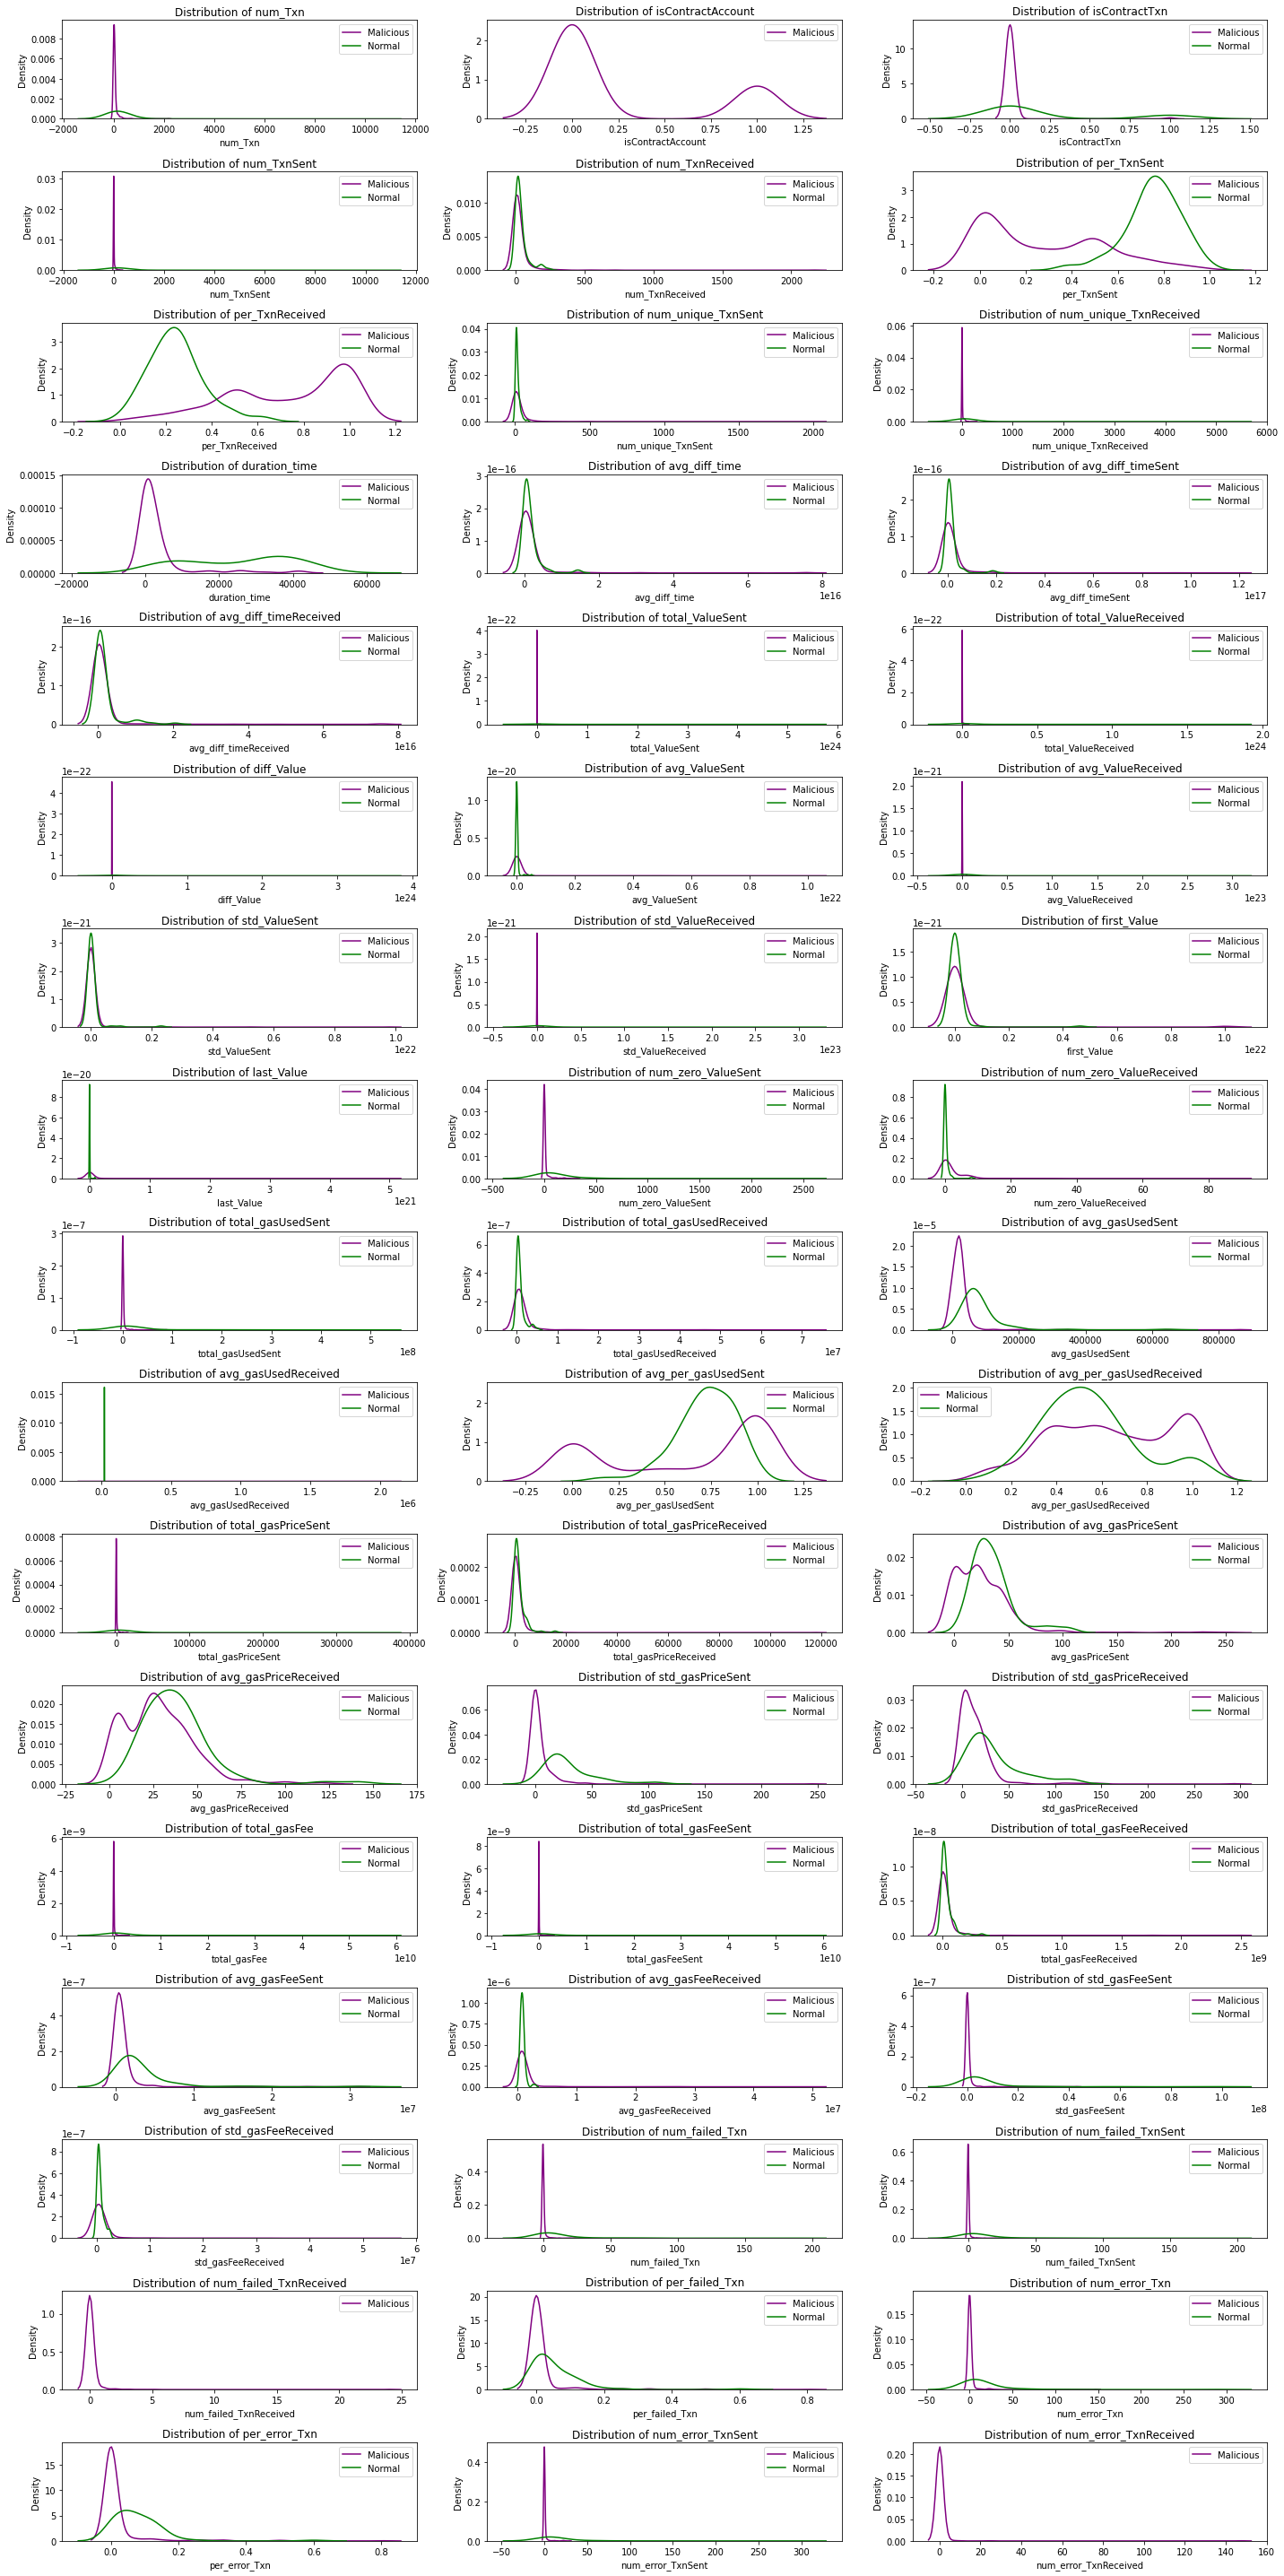

In [288]:
# plot
plt.figure(figsize=(20, 40))

for i, col in enumerate(df.columns[:-1]):
    plt.subplot(17, 3, i + 1)
    subset_mal = df[df['isMal'] == 1]
    subset_normal = df[df['isMal'] == 0]
    sns.kdeplot(subset_mal[col], label = 'Malicious', color = 'purple')
    sns.kdeplot(subset_normal[col], label = 'Normal', color = 'green')
    plt.legend(); plt.title('Distribution of %s' % col)
    
plt.tight_layout()

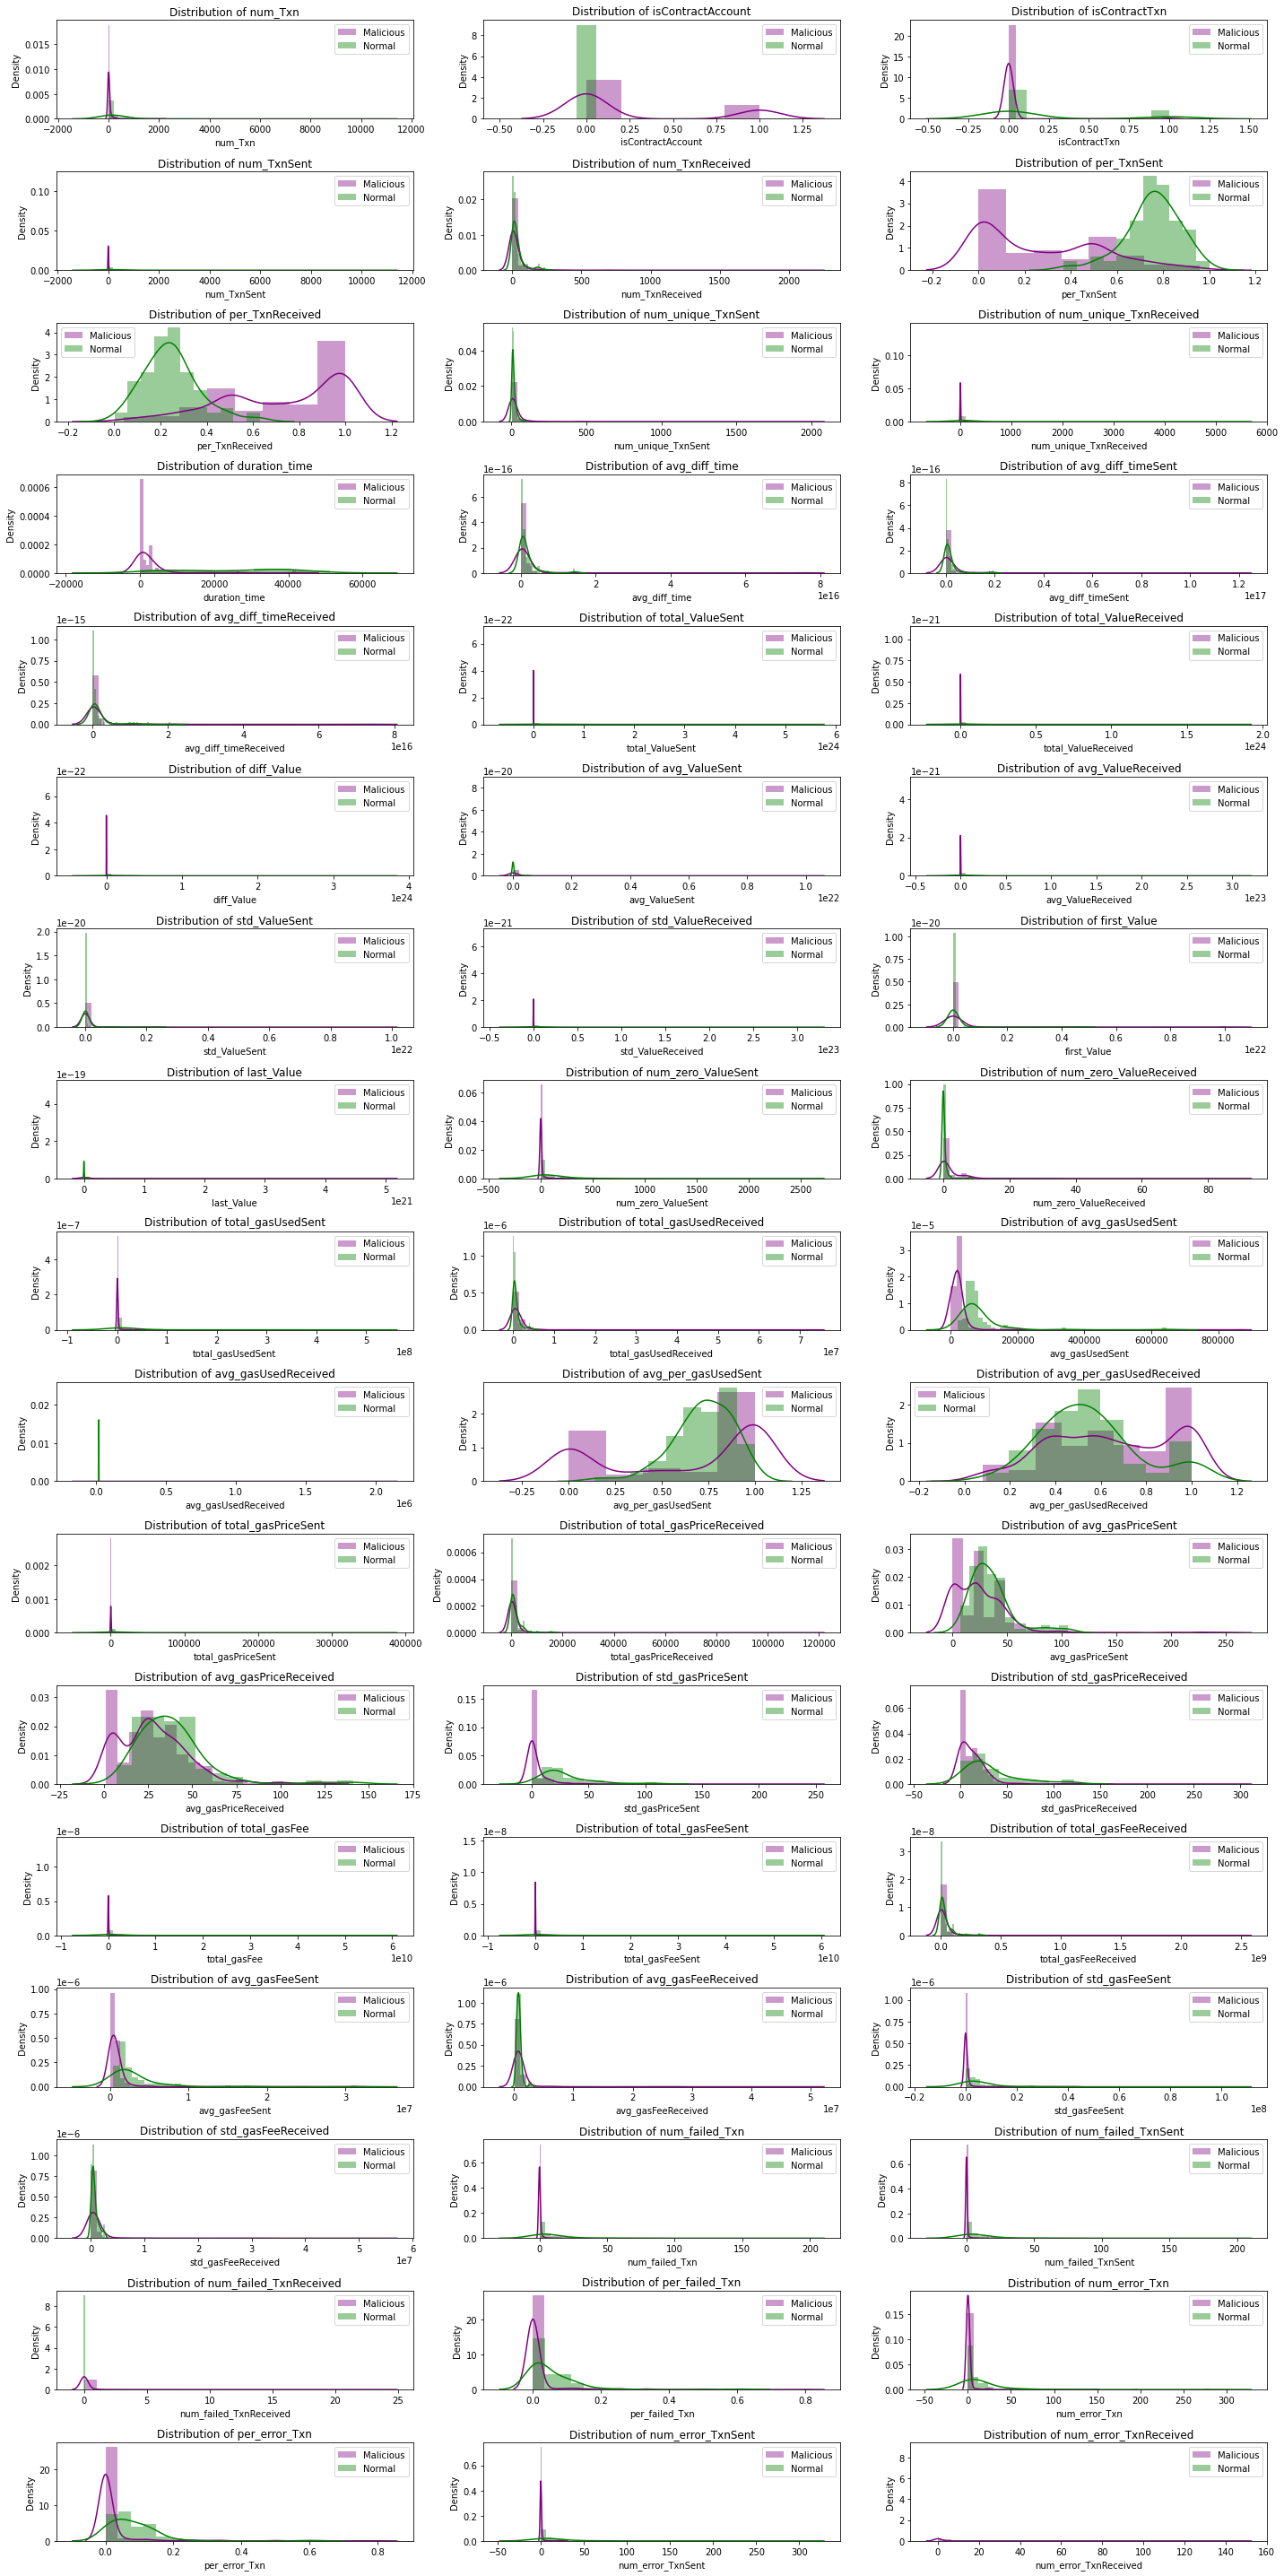

In [289]:
# plot
plt.figure(figsize=(20, 40))

for i, col in enumerate(df.columns[:-1]):
    plt.subplot(17, 3, i + 1)
    subset_mal = df[df['isMal'] == 1]
    subset_normal = df[df['isMal'] == 0]
    sns.distplot(subset_mal[col], label = 'Malicious', color = 'purple', kde=True)
    sns.distplot(subset_normal[col], label = 'Normal', color = 'green', kde=True)
    plt.legend(); plt.title('Distribution of %s' % col)
    
plt.tight_layout()

### Correlation

In [290]:
df.corr()['isMal'].sort_values()

duration_time             -0.657472
per_TxnSent               -0.557039
std_gasPriceSent          -0.470510
avg_gasUsedSent           -0.388856
num_failed_TxnSent        -0.374567
num_failed_Txn            -0.369390
num_error_TxnSent         -0.369097
isContractTxn             -0.366992
std_gasFeeSent            -0.364556
num_error_Txn             -0.337983
avg_gasFeeSent            -0.321074
num_zero_ValueSent        -0.305556
per_error_Txn             -0.289512
total_gasUsedSent         -0.286206
std_gasPriceReceived      -0.278370
total_gasPriceSent        -0.240308
num_TxnSent               -0.232743
num_Txn                   -0.231364
per_failed_Txn            -0.196400
total_gasFeeSent          -0.191592
total_gasFee              -0.191146
num_unique_TxnReceived    -0.179011
avg_gasPriceReceived      -0.174898
avg_gasPriceSent          -0.134077
total_ValueReceived       -0.106691
total_ValueSent           -0.102293
diff_Value                -0.099664
std_ValueReceived         -0

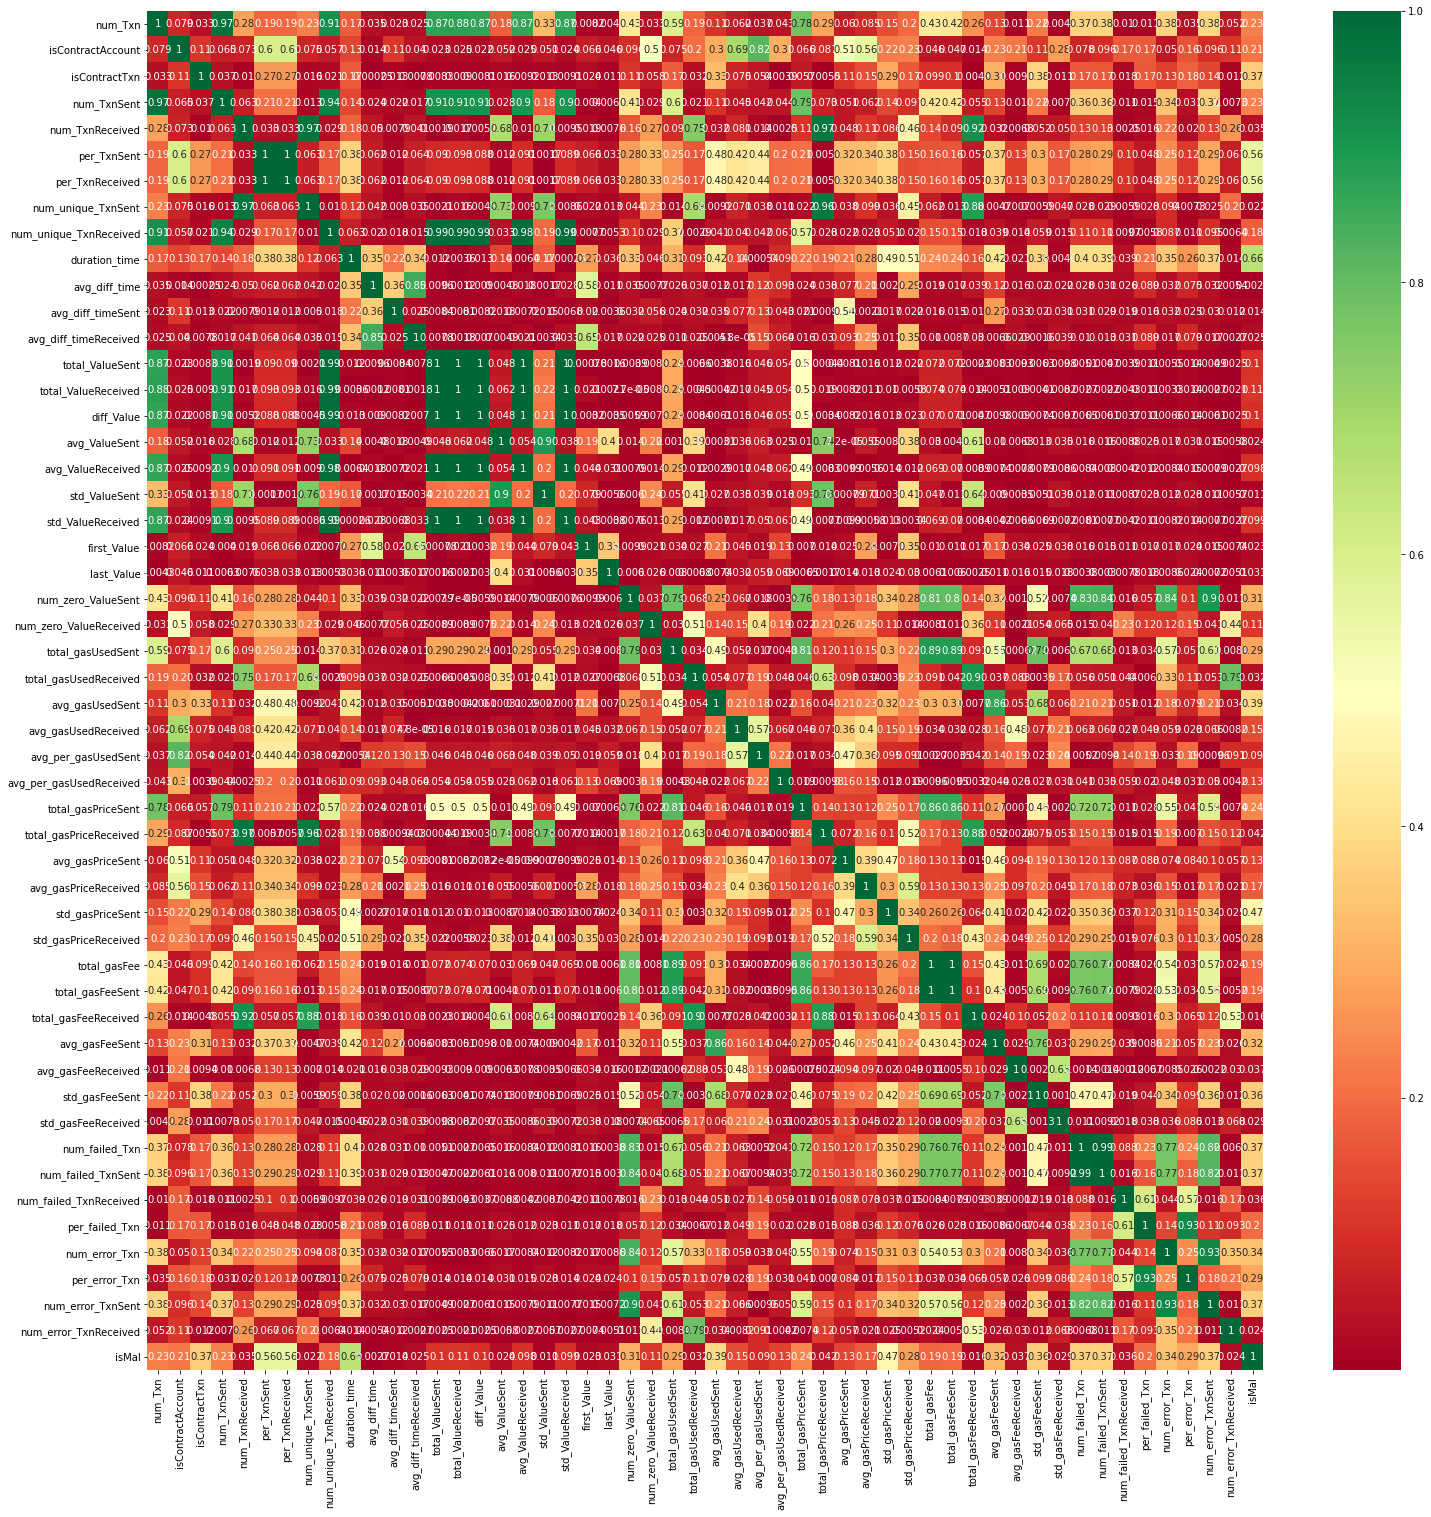

In [291]:
# plot correlation matrix
corr_matrix = df.corr().abs()

plt.figure(figsize = (25,25))
g = sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn")

## Model Training & Evaluation -> LP5, LP6

### Feature Selection

In [138]:
def select_k_best(df, k):
    y = df['isMal']
    X =  df.drop(['isMal'], axis = 1)

    score_func=chi2
    #score_func=
    bestfeatures = SelectKBest(score_func=score_func, k=k)
    fit = bestfeatures.fit(abs(X), y)
    
    scores = pd.DataFrame(fit.scores_)
    columns = pd.DataFrame(X.columns)

    featureScores = pd.concat([columns, scores],axis=1)
    featureScores.columns = ['Features', 'Score']  
    k_most_important=featureScores.nlargest(k, 'Score')
    print(k_most_important)
    
    array=[]
    for i in (k_most_important['Features']):
        array.append(i)
    
    X = X[array]
    
    # split into train and test dataset with 20% split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.20,
                                                        random_state=0)
    
    return X_train, X_test, y_train, y_test

In [292]:
##X_train, X_test, y_train, y_test = select_k_best(df, k=30)
y = df['isMal']
X =  df.drop(['isMal'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=seed)

### Model Training (with standard machine learning models)

In [293]:
def evaluate(X_train, X_test, y_train, y_test, seed):
    
    model_name_list = ['Logistic Regression', 'SVM',
                       'KNN', 'Random Forest',
                       'XGBoost']
    
    model1 = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=seed)
    model2 = SVC(random_state=seed)
    model3 = KNeighborsClassifier(n_neighbors=10)
    model4 = RandomForestClassifier(random_state=seed)
    model5 = XGBClassifier(eval_metric='logloss', random_state=seed)


    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    results = pd.DataFrame(columns=['val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'val_auc', \
                                    'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_auc'],index = model_name_list)
    

    for i, model in enumerate([model1, model2, model3, model4, model5]):
        
        # train and validate with 10 fold cross validation
        kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
        train_scores = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=True)
        val_accuracy = np.mean(train_scores['test_accuracy'])
        val_precision = np.mean(train_scores['test_precision'])
        val_recall = np.mean(train_scores['test_recall'])
        val_f1 = np.mean(train_scores['test_f1'])
        val_auc = np.mean(train_scores['test_roc_auc'])
        
        # predict with test data
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)

        test_accuracy = accuracy_score(y_test, prediction)
        test_precision = precision_score(y_test, prediction)
        test_recall = recall_score(y_test, prediction)
        test_f1 = f1_score(y_test, prediction)
        test_auc = roc_auc_score(y_test, prediction)

        model_name = model_name_list[i]
        results.loc[model_name, :] = [val_accuracy, val_precision, val_recall, val_f1, val_auc, \
                                    test_accuracy, test_precision, test_recall, test_f1, test_auc]
    
    return results

In [294]:
evaluate(X_train, X_test, y_train, y_test, seed)

,val_accuracy,val_precision,val_recall,val_f1,val_auc,test_accuracy,test_precision,test_recall,test_f1,test_auc
Logistic Regression,0.858824,0.955820,0.880354,0.914815,0.795483,0.875000,0.942857,0.908257,0.925234,0.796234
SVM,0.872549,0.873333,0.997727,0.931354,0.825464,0.851562,0.851562,1.000000,0.919831,0.500000
KNN,0.888235,0.923547,0.950253,0.936462,0.859768,0.859375,0.902655,0.935780,0.918919,0.678416
Random Forest,0.968627,0.975648,0.988737,0.982070,0.991655,0.945312,0.955357,0.981651,0.968326,0.859247
XGBoost,0.966667,0.973478,0.988687,0.980974,0.989199,0.945312,0.963636,0.972477,0.968037,0.880975


### Hyperparameter Tuning

#### Random Forest

In [295]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [296]:
# use the random grid to search for best hyperparameters
rf = RandomForestClassifier()

# random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, n_jobs = -1, random_state=seed)

# fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=2)

In [297]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [298]:
best_rf = rf_random.best_estimator_
prediction = best_rf.predict(X_test)

In [299]:
print(accuracy_score(y_test, prediction))
print(precision_score(y_test, prediction))
print(recall_score(y_test, prediction))
print(f1_score(y_test, prediction))

print(confusion_matrix(y_test, prediction))

print(classification_report(y_test,prediction))

0.9375
0.9469026548672567
0.981651376146789
0.963963963963964
[[ 13   6]
 [  2 107]]
              precision    recall  f1-score   support

           0       0.87      0.68      0.76        19
           1       0.95      0.98      0.96       109

    accuracy                           0.94       128
   macro avg       0.91      0.83      0.86       128
weighted avg       0.93      0.94      0.93       128



#### XGBoost

In [300]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
learning_rate = [0.01, 0.15, 0.3]
subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
colsample_bytree = [0.6, 0.7, 0.9, 1.0]

XGB_grid = {'learning_rate': learning_rate,
          'max_depth': max_depth,
          'n_estimators': n_estimators,
          'subsample': subsample,
          'colsample_bytree': colsample_bytree}
XGB_grid

{'learning_rate': [0.01, 0.15, 0.3],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
 'colsample_bytree': [0.6, 0.7, 0.9, 1.0]}

In [301]:
XGB = XGBClassifier(eval_metric='logloss')
XGB_random = RandomizedSearchCV(estimator=XGB, param_distributions = XGB_grid, n_iter = 100, cv = 5, verbose=2, n_jobs = -1, random_state=seed)
XGB_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [302]:
XGB_random.best_params_

{'subsample': 0.8,
 'n_estimators': 1000,
 'max_depth': 10,
 'learning_rate': 0.15,
 'colsample_bytree': 0.6}

In [303]:
best_XGB = XGB_random.best_estimator_
prediction = best_XGB.predict(X_test)

In [304]:
print(accuracy_score(y_test, prediction))
print(precision_score(y_test, prediction))
print(recall_score(y_test, prediction))
print(f1_score(y_test, prediction))

print(confusion_matrix(y_test, prediction))

print(classification_report(y_test,prediction))

0.953125
0.963963963963964
0.981651376146789
0.9727272727272728
[[ 15   4]
 [  2 107]]
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        19
           1       0.96      0.98      0.97       109

    accuracy                           0.95       128
   macro avg       0.92      0.89      0.90       128
weighted avg       0.95      0.95      0.95       128



### Feature Importance

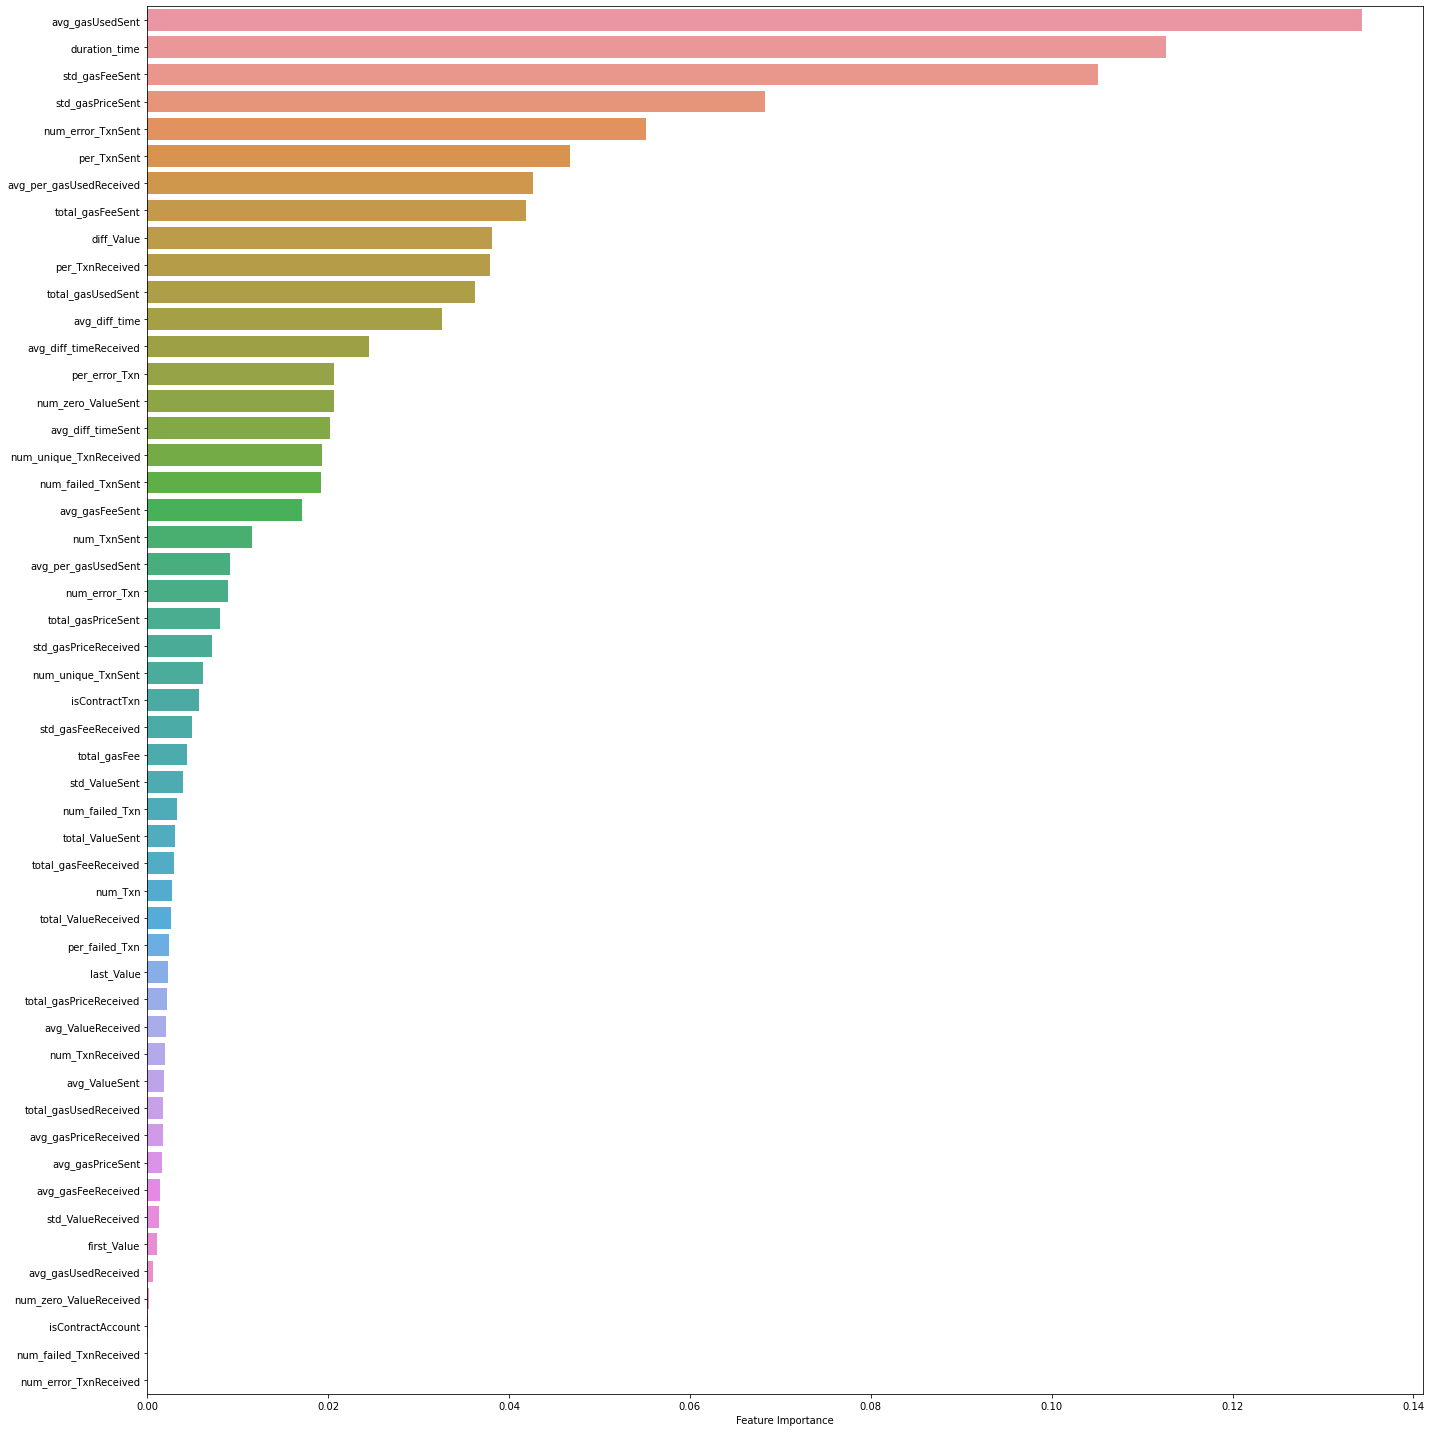

In [305]:
# feature importance with tuned Random Forest model
ranks = np.argsort(-best_rf.feature_importances_)
f, ax = plt.subplots(figsize=(20, 20))

sns.barplot(x=best_rf.feature_importances_[ranks], y=X_train.columns.values[ranks], orient='h')
ax.set_xlabel('Feature Importance')
plt.tight_layout()
plt.show()

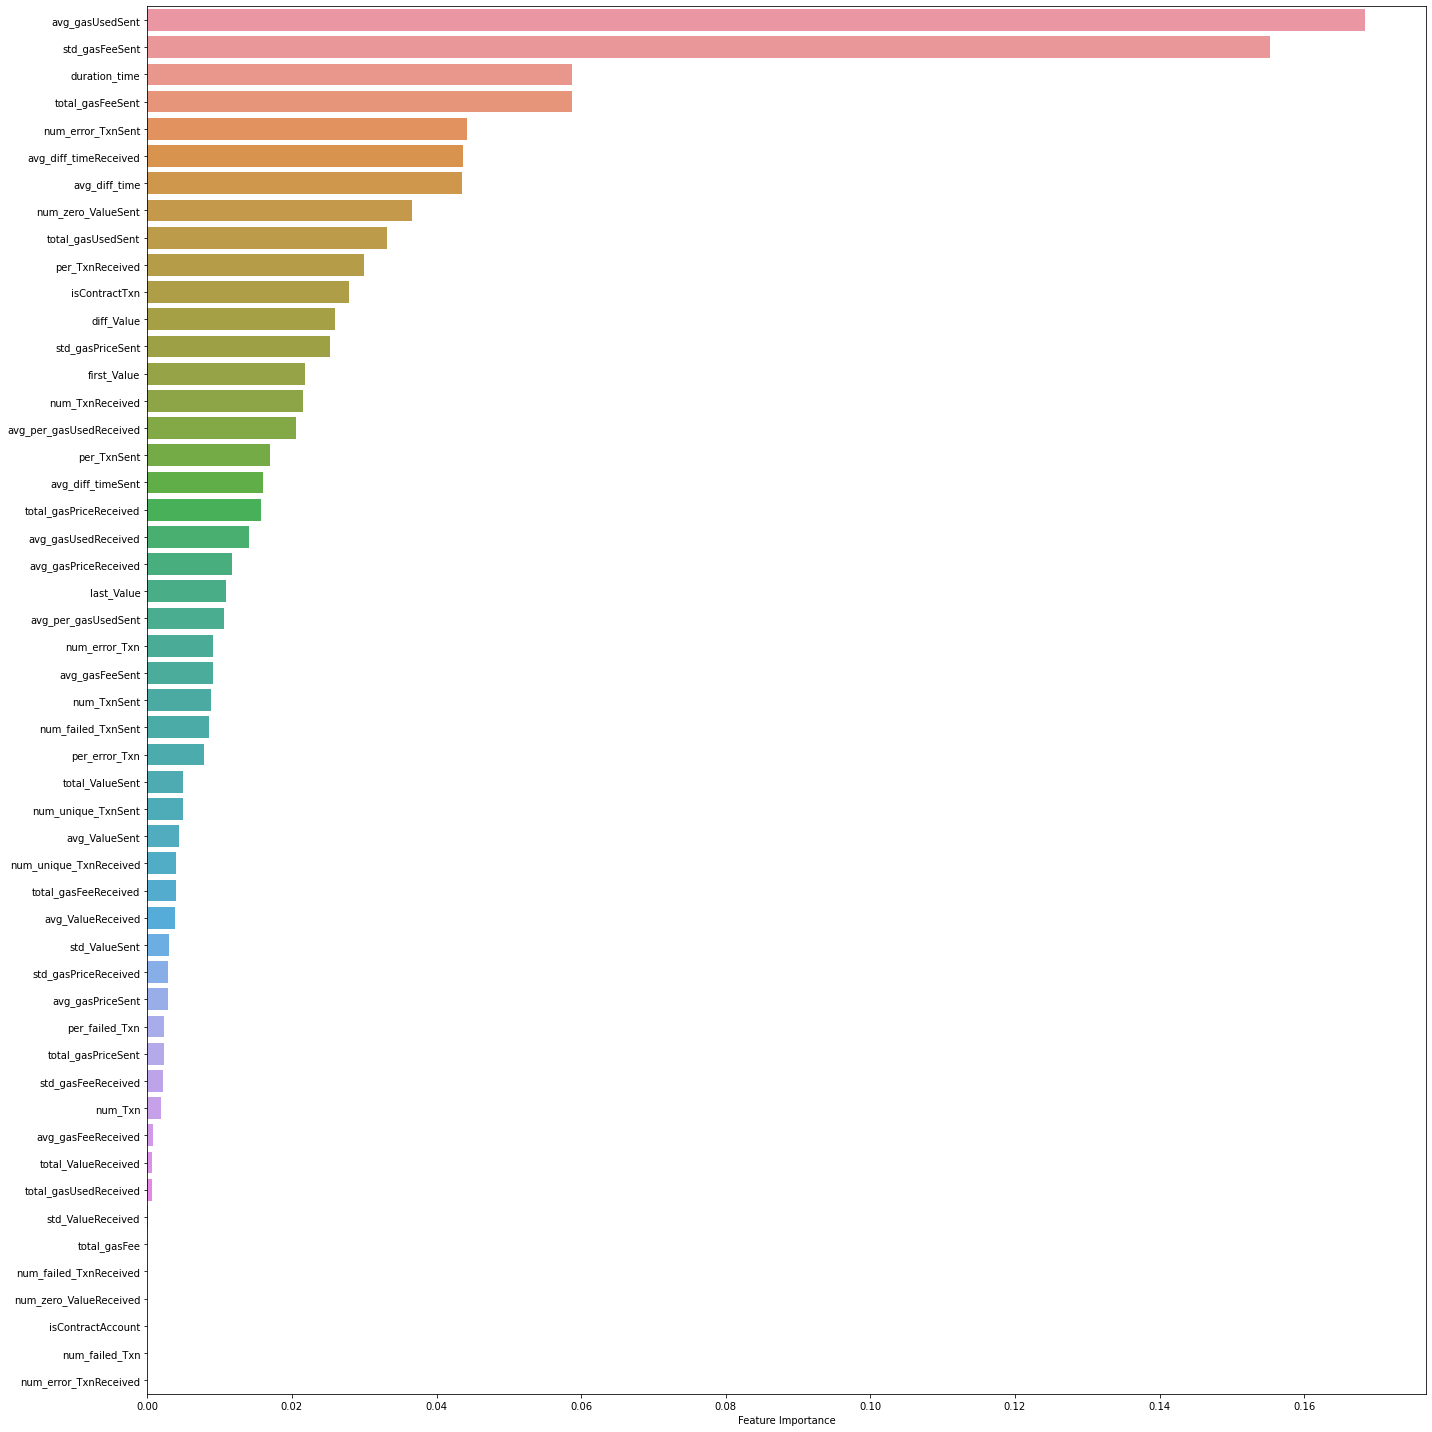

In [306]:
# feature importance with XGBoost model
ranks = np.argsort(-best_XGB.feature_importances_)
f, ax = plt.subplots(figsize=(20, 20))

sns.barplot(x=best_XGB.feature_importances_[ranks], y=X_train.columns.values[ranks], orient='h')
ax.set_xlabel('Feature Importance')
plt.tight_layout()
plt.show()